In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

!pip install keras-metrics
import keras
import keras_metrics

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Построение нейросети для задачи фильтрации изображений, на которых находится человек

## Проверка на возможность декодирования изображений для работы с tensorflow

In [3]:
def check_image(img_path):
    image_contents = tf.io.read_file(img_path)
    try:
        image = tf.image.decode_jpeg(image_contents, channels=3)
    except:
        return False
    return True

In [4]:
data_dir_1 = os.path.join('/content/drive/MyDrive/HumanClassification13k')

train_Human_dir = os.path.join('/content/drive/MyDrive/HumanClassification13k/Human')
train_NoHuman_dir = os.path.join('/content/drive/MyDrive/HumanClassification13k/NoHuman')
train_Human_names = [i for i in os.listdir(train_Human_dir) if check_image(os.path.join(train_Human_dir, i))]
train_NoHuman_names = [i for i in os.listdir(train_NoHuman_dir) if check_image(os.path.join(train_NoHuman_dir, i))]

print('Total training with Human images:', len(train_Human_names))
print('Total training with NoHuman images:', len(train_NoHuman_names))

Total training with Human images: 6617
Total training with NoHuman images: 6693


### Определим новую директорую для проверенных изображений и перенесем их в нее


In [6]:
new_data_dir_1 = 'drive/MyDrive/FinalHumanClassification13k/'
new_train_Human_dir = 'drive/MyDrive/FinalHumanClassification13k/Human/'
new_train_NoHuman_dir = 'drive/MyDrive/FinalHumanClassification13k/NoHuman/'

In [7]:
from shutil import copyfile
for i in train_Human_names:
    src = os.path.join(train_Human_dir, i)
    dst = os.path.join(new_train_Human_dir, i)
    copyfile(src, dst)
for i in train_NoHuman_names:
    src = os.path.join(train_NoHuman_dir, i)
    dst = os.path.join(new_train_NoHuman_dir, i)
    copyfile(src, dst)

In [8]:
new_Human_dir = os.path.join('/content/drive/MyDrive/FinalHumanClassification13k/Human')
new_Human_names = os.listdir(train_Human_dir)
new_NoHuman_dir = os.path.join('/content/drive/MyDrive/FinalHumanClassification13k/NoHuman')
new_NoHuman_names = os.listdir(train_NoHuman_dir)
print('Total training with Human images:', len(new_Human_names))
print('Total training with NoHuman images:', len(new_NoHuman_names))

Total training with Human images: 6618
Total training with NoHuman images: 6693


## Топология нейронной сети

In [9]:
model_1 = tf.keras.models.Sequential([
    # This is the first convolution
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)), #нормализация признаков
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convoalution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 нейронов в скрытом слое
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0

## Зададим основные метрики, с помощью которых будем оценивать результат

In [10]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Поделим наши данные на тренировочные(80%) и валидационные(20%)

In [11]:
train_ds_1 = tf.keras.preprocessing.image_dataset_from_directory(
  new_data_dir_1,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(180, 180))
  #batch_size=500)

val_ds_1 = tf.keras.preprocessing.image_dataset_from_directory(
  new_data_dir_1,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(180, 180))
  #batch_size=121)

Found 13310 files belonging to 2 classes.
Using 10648 files for training.
Found 13310 files belonging to 2 classes.
Using 2662 files for validation.


## Скомпилируем нашу модель, при этом указав функцию потерь, функцию оптимизации и метрики

In [12]:
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['acc', f1_m, precision_m, recall_m])

## Для более удобного и адаптивного оценивания модели используем tensorboard 

In [16]:
%load_ext tensorboard
import tensorflow as tf
import datetime, os
#%reload_ext tensorboard
logdir_1 = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback_1 = tf.keras.callbacks.TensorBoard(logdir_1, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Этап обучения

In [14]:
epochs = 4
HumanClassification = model_1.fit(
  train_ds_1,
  validation_data=val_ds_1,
  #steps_per_epoch=20,
  epochs=epochs,
  callbacks=[tensorboard_callback_1]
  )

Epoch 1/4
333/333 [==============================] - 394s 1s/step - loss: 0.4736 - acc: 0.7678 - f1_m: 0.7343 - precision_m: 0.7483 - recall_m: 0.7697 - val_loss: 0.3156 - val_acc: 0.8727 - val_f1_m: 0.8829 - val_precision_m: 0.8089 - val_recall_m: 0.9782
Epoch 2/4
333/333 [==============================] - 369s 1s/step - loss: 0.2748 - acc: 0.8894 - f1_m: 0.8863 - precision_m: 0.8796 - recall_m: 0.9108 - val_loss: 0.2163 - val_acc: 0.9125 - val_f1_m: 0.9119 - val_precision_m: 0.9361 - val_recall_m: 0.8930
Epoch 3/4
333/333 [==============================] - 371s 1s/step - loss: 0.1944 - acc: 0.9275 - f1_m: 0.9255 - precision_m: 0.9185 - recall_m: 0.9398 - val_loss: 0.1945 - val_acc: 0.9222 - val_f1_m: 0.9151 - val_precision_m: 0.9444 - val_recall_m: 0.8961
Epoch 4/4
333/333 [==============================] - 370s 1s/step - loss: 0.1713 - acc: 0.9363 - f1_m: 0.9349 - precision_m: 0.9255 - recall_m: 0.9495 - val_loss: 0.1718 - val_acc: 0.9384 - val_f1_m: 0.9284 - val_precision_m: 0.8969

Оценивание наших результатов

In [ ]:
%tensorboard --logdir_1 logs

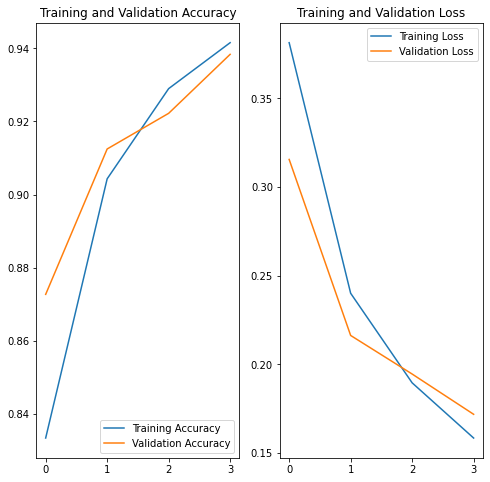

In [19]:
acc = HumanClassification.history['acc']
val_acc = HumanClassification.history['val_acc']

loss = HumanClassification.history['loss']
val_loss = HumanClassification.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 2. Модель для фильтрации людей, которые одеты в подходящую одежду(торс должен быть обнаженным или облегающим)

## Проверка на возможность декодирования изображений для работы с tensorflow

In [25]:
data_dir_2 = os.path.join('/content/drive/MyDrive/ClothesDataset')

train_Good_dir = os.path.join('/content/drive/MyDrive/ClothesDataset/Good')
train_Bad_dir = os.path.join('/content/drive/MyDrive/ClothesDataset/Bad')
train_GoodClothes = [i for i in os.listdir(train_Good_dir) if check_image(os.path.join(train_Good_dir, i))]
train_BadClothes = [i for i in os.listdir(train_Bad_dir) if check_image(os.path.join(train_Bad_dir, i))]

In [26]:
print('Total Good clothes images:', len(train_GoodClothes))
print('Total Bad clothes images:', len(train_BadClothes))

Total Good clothes images: 573
Total Bad clothes images: 619


### Определим новую директорию и перенесем проверенные изображения в нее

In [27]:
new_data_dir_2 = 'drive/MyDrive/FinalClothesDataset1k/'
new_GoodClothes_dir = 'drive/MyDrive/FinalClothesDataset1k/Good/'
new_BadClothes_dir = 'drive/MyDrive/FinalClothesDataset1k/Bad/'

In [28]:
from shutil import copyfile
for i in train_GoodClothes:
    src = os.path.join(train_GoodClothes_dir, i)
    dst = os.path.join(new_GoodClothes_dir, i)
    copyfile(src, dst)

for i in train_BadClothes:
    src = os.path.join(train_BadClothes_dir, i)
    dst = os.path.join(new_BadClothes_dir, i)
    copyfile(src, dst)

## Топология нейросети


In [44]:
model__2 = tf.keras.models.Sequential([
    # This is the first convolution
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)), #нормализация признаков
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convoalution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 нейронов в скрытом слое
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model__2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 87, 87, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 41, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 20, 20, 64)       

In [45]:
train_ds_2 = tf.keras.preprocessing.image_dataset_from_directory(
  new_data_dir_2,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(180, 180))
  #batch_size=500)

val_ds_2 = tf.keras.preprocessing.image_dataset_from_directory(
  new_data_dir_2,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(180, 180))
  #batch_size=121)

Found 1192 files belonging to 2 classes.
Using 954 files for training.
Found 1192 files belonging to 2 classes.
Using 238 files for validation.


In [46]:
model__2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['acc', f1_m, precision_m, recall_m])

In [47]:
%reload_ext tensorboard
#%reload_ext tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback_2 = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

## Этап обучения

In [48]:
epochs = 8
history__2 = model__2.fit(
  train_ds_2,
  validation_data=val_ds_2,
  #steps_per_epoch=20,
  epochs=epochs,
  callbacks=[tensorboard_callback_2]
  )

Epoch 1/8
30/30 [==============================] - 39s 1s/step - loss: 0.6916 - acc: 0.5931 - f1_m: 0.3179 - precision_m: 0.3693 - recall_m: 0.3750 - val_loss: 0.6385 - val_acc: 0.6933 - val_f1_m: 0.6997 - val_precision_m: 0.6019 - val_recall_m: 0.8492
Epoch 2/8
30/30 [==============================] - 37s 1s/step - loss: 0.6209 - acc: 0.7045 - f1_m: 0.7282 - precision_m: 0.6753 - recall_m: 0.8327 - val_loss: 0.6492 - val_acc: 0.6218 - val_f1_m: 0.6904 - val_precision_m: 0.5411 - val_recall_m: 0.9645
Epoch 3/8
30/30 [==============================] - 37s 1s/step - loss: 0.5529 - acc: 0.7343 - f1_m: 0.7246 - precision_m: 0.7283 - recall_m: 0.7644 - val_loss: 0.4689 - val_acc: 0.7815 - val_f1_m: 0.7666 - val_precision_m: 0.6916 - val_recall_m: 0.8731
Epoch 4/8
30/30 [==============================] - 37s 1s/step - loss: 0.4757 - acc: 0.7837 - f1_m: 0.7691 - precision_m: 0.7602 - recall_m: 0.8122 - val_loss: 0.4678 - val_acc: 0.7899 - val_f1_m: 0.7480 - val_precision_m: 0.6802 - val_recal

In [ ]:
%tensorboard --logdir_ logs

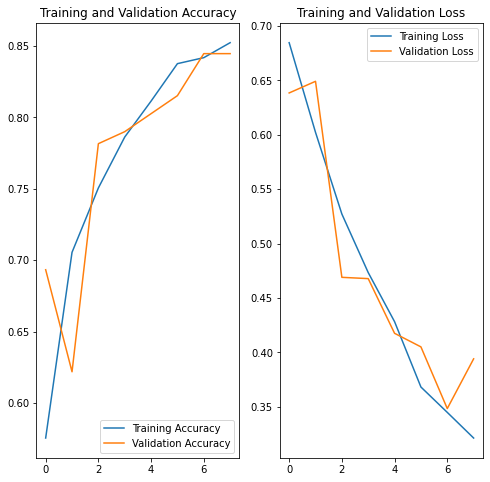

In [50]:
acc = history__2.history['acc']
val_acc = history__2.history['val_acc']

loss = history__2.history['loss']
val_loss = history__2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 3. Связывание нейросетей и тестирование

Saving kiborgi-fantastika-organy-pesochnica-4488416.jpg to kiborgi-fantastika-organy-pesochnica-4488416 (2).jpg
kiborgi-fantastika-organy-pesochnica-4488416.jpg is a no human with accuracy 99.43046569824219%


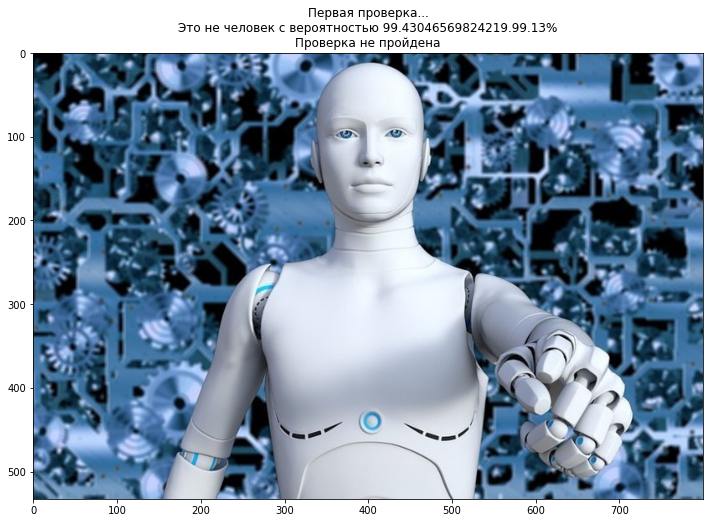

In [71]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import cv2
uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  img_normal = image.load_img(path)
  img = image.load_img(path, target_size=(180, 180))
  imgplt = cv2.imread(path)

  fig, ax = plt.subplots()
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  humanClassification = model_1.predict(images, batch_size=10)
  clothesClassification = model__2.predict(images, batch_size=10)

  if humanClassification[0] < 0.5:
    print(fn + " is a human with accuracy {}%".format(float((1-humanClassification[0])*100)))
    result = "Первая проверка...\nЭто человек с вероятностью {}".format(float((1-humanClassification[0])*100))
    if clothesClassification[0] < 0.5:
      result+= "\nВторая проверка...\nВнешникй вид соответствует параметрам с вероятностью {}".format(float((1-clothesClassification[0])*100))
      result+= "\nПроверка пройдена!"
    else:
      result+= "\nВторая проверка...\nВнешникй вид не соответствует параметрам с вероятностью {}".format(float((clothesClassification[0])*100))
      result+="\nПроверка не пройдена!"

  else:
    result = "Первая проверка...\nЭто не человек с вероятностью {}.99.13%".format(float(humanClassification[0]*100))
    result+= "\nПроверка не пройдена"
    print(fn + " is a no human with accuracy {}%".format(float(humanClassification[0]*100)))

  ax.imshow(img_normal)
  ax.set_title(result)
  fig.set_figwidth(12)    
  fig.set_figheight(12)

  plt.show()

Saving 1499990138_0 0 5143 2894_1920x0_80_0_0_8782f9c8b1778d94e029c9c42420aa54.jpg to 1499990138_0 0 5143 2894_1920x0_80_0_0_8782f9c8b1778d94e029c9c42420aa54 (3).jpg
1499990138_0 0 5143 2894_1920x0_80_0_0_8782f9c8b1778d94e029c9c42420aa54.jpg is a no human with accuracy 98.99143981933594%


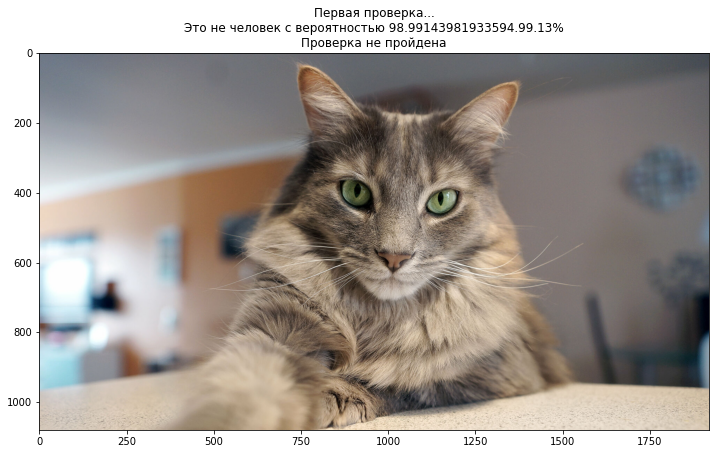

In [70]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  img_normal = image.load_img(path)
  img = image.load_img(path, target_size=(180, 180))
  imgplt = cv2.imread(path)

  fig, ax = plt.subplots()
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  humanClassification = model_1.predict(images, batch_size=10)
  clothesClassification = model__2.predict(images, batch_size=10)

  if humanClassification[0] < 0.5:
    print(fn + " is a human with accuracy {}%".format(float((1-humanClassification[0])*100)))
    result = "Первая проверка...\nЭто человек с вероятностью {}".format(float((1-humanClassification[0])*100))
    if clothesClassification[0] < 0.5:
      result+= "\nВторая проверка...\nВнешникй вид соответствует параметрам с вероятностью {}".format(float((1-clothesClassification[0])*100))
      result+= "\nПроверка пройдена!"
    else:
      result+= "\nВторая проверка...\nВнешникй вид не соответствует параметрам с вероятностью {}".format(float((clothesClassification[0])*100))
      result+="\nПроверка не пройдена!"

  else:
    result = "Первая проверка...\nЭто не человек с вероятностью {}.99.13%".format(float(humanClassification[0]*100))
    result+= "\nПроверка не пройдена"
    print(fn + " is a no human with accuracy {}%".format(float(humanClassification[0]*100)))

  ax.imshow(img_normal)
  ax.set_title(result)
  fig.set_figwidth(12)    
  fig.set_figheight(12)

  plt.show()

Saving -LMllA40HjQ.jpg to -LMllA40HjQ.jpg
-LMllA40HjQ.jpg is a human with accuracy 98.23127746582031%


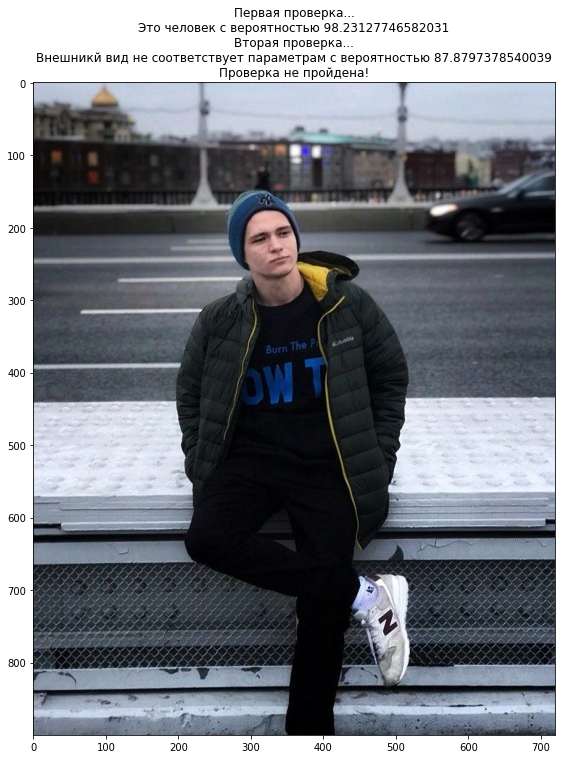

In [72]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  img_normal = image.load_img(path)
  img = image.load_img(path, target_size=(180, 180))
  imgplt = cv2.imread(path)

  fig, ax = plt.subplots()
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  humanClassification = model_1.predict(images, batch_size=10)
  clothesClassification = model__2.predict(images, batch_size=10)

  if humanClassification[0] < 0.5:
    print(fn + " is a human with accuracy {}%".format(float((1-humanClassification[0])*100)))
    result = "Первая проверка...\nЭто человек с вероятностью {}".format(float((1-humanClassification[0])*100))
    if clothesClassification[0] < 0.5:
      result+= "\nВторая проверка...\nВнешникй вид соответствует параметрам с вероятностью {}".format(float((1-clothesClassification[0])*100))
      result+= "\nПроверка пройдена!"
    else:
      result+= "\nВторая проверка...\nВнешникй вид не соответствует параметрам с вероятностью {}".format(float((clothesClassification[0])*100))
      result+="\nПроверка не пройдена!"

  else:
    result = "Первая проверка...\nЭто не человек с вероятностью {}.99.13%".format(float(humanClassification[0]*100))
    result+= "\nПроверка не пройдена"
    print(fn + " is a no human with accuracy {}%".format(float(humanClassification[0]*100)))

  ax.imshow(img_normal)
  ax.set_title(result)
  fig.set_figwidth(12)    
  fig.set_figheight(12)

  plt.show()

Saving a66cc19d82669797c2af8f46f0bb6be3.jpg to a66cc19d82669797c2af8f46f0bb6be3.jpg
a66cc19d82669797c2af8f46f0bb6be3.jpg is a human with accuracy 99.90440368652344%


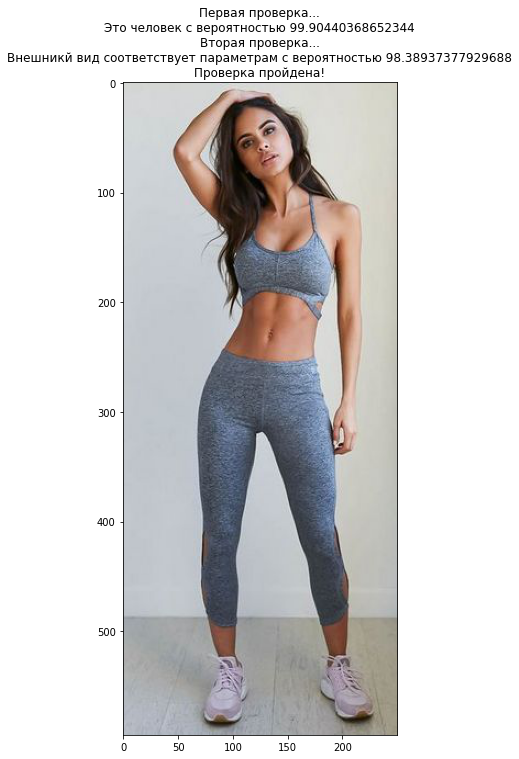

In [74]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  img_normal = image.load_img(path)
  img = image.load_img(path, target_size=(180, 180))
  imgplt = cv2.imread(path)

  fig, ax = plt.subplots()
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  humanClassification = model_1.predict(images, batch_size=10)
  clothesClassification = model__2.predict(images, batch_size=10)

  if humanClassification[0] < 0.5:
    print(fn + " is a human with accuracy {}%".format(float((1-humanClassification[0])*100)))
    result = "Первая проверка...\nЭто человек с вероятностью {}".format(float((1-humanClassification[0])*100))
    if clothesClassification[0] < 0.5:
      result+= "\nВторая проверка...\nВнешникй вид соответствует параметрам с вероятностью {}".format(float((1-clothesClassification[0])*100))
      result+= "\nПроверка пройдена!"
    else:
      result+= "\nВторая проверка...\nВнешникй вид не соответствует параметрам с вероятностью {}".format(float((clothesClassification[0])*100))
      result+="\nПроверка не пройдена!"

  else:
    result = "Первая проверка...\nЭто не человек с вероятностью {}.99.13%".format(float(humanClassification[0]*100))
    result+= "\nПроверка не пройдена"
    print(fn + " is a no human with accuracy {}%".format(float(humanClassification[0]*100)))

  ax.imshow(img_normal)
  ax.set_title(result)
  fig.set_figwidth(12)    
  fig.set_figheight(12)

  plt.show()

Saving 6c43c9e8bf1e9f513d2c71a514e1a302.jpg to 6c43c9e8bf1e9f513d2c71a514e1a302.jpg
6c43c9e8bf1e9f513d2c71a514e1a302.jpg is a human with accuracy 90.73119354248047%


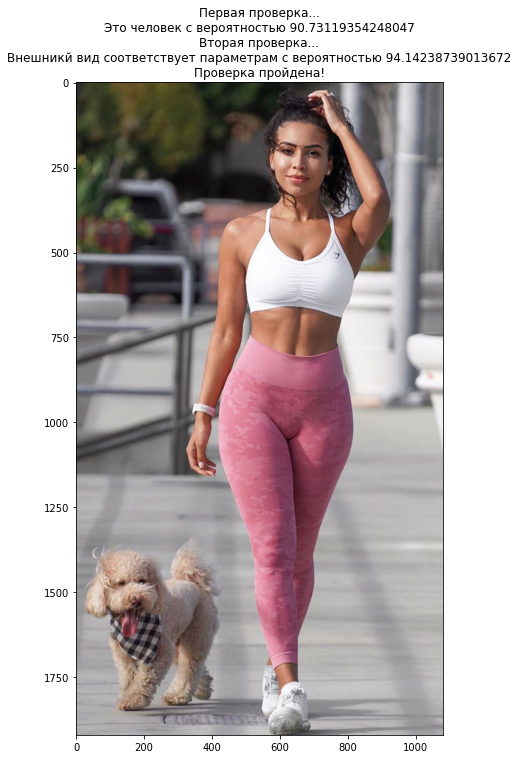

In [76]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  img_normal = image.load_img(path)
  img = image.load_img(path, target_size=(180, 180))
  imgplt = cv2.imread(path)

  fig, ax = plt.subplots()
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  humanClassification = model_1.predict(images, batch_size=10)
  clothesClassification = model__2.predict(images, batch_size=10)

  if humanClassification[0] < 0.5:
    print(fn + " is a human with accuracy {}%".format(float((1-humanClassification[0])*100)))
    result = "Первая проверка...\nЭто человек с вероятностью {}".format(float((1-humanClassification[0])*100))
    if clothesClassification[0] < 0.5:
      result+= "\nВторая проверка...\nВнешникй вид соответствует параметрам с вероятностью {}".format(float((1-clothesClassification[0])*100))
      result+= "\nПроверка пройдена!"
    else:
      result+= "\nВторая проверка...\nВнешникй вид не соответствует параметрам с вероятностью {}".format(float((clothesClassification[0])*100))
      result+="\nПроверка не пройдена!"

  else:
    result = "Первая проверка...\nЭто не человек с вероятностью {}.99.13%".format(float(humanClassification[0]*100))
    result+= "\nПроверка не пройдена"
    print(fn + " is a no human with accuracy {}%".format(float(humanClassification[0]*100)))

  ax.imshow(img_normal)
  ax.set_title(result)
  fig.set_figwidth(12)    
  fig.set_figheight(12)

  plt.show()